<h1>Introduction</h1>

**Dataset**

The primary dataset used for this classification task was pulled from the National Cancer Institute's <a href="https://seer.cancer.gov/data/">SEER Incidence Data</a>, and the data chosen came from the <a href="https://seer.cancer.gov/data-software/documentation/seerstat/nov2020/">Incidence - SEER Research Data, 18 Registries, Nov 2020 Sub (2000-2018)</a> database. The dataset is composed of cancer incidences, with each instance accompanied with features such as patient demographics, primary tumor site, tumor morphology, stage at diagnosis, and first course of treatment, as well as an updated vital status of the patient. For this project, only the breast cancer incidences were considered.

**Data Availability**

The datasets used and/or analysed during the current study are available from the publisher, the National Cancer Institute, upon reasonable <a href="https://seerdataaccess.cancer.gov/seer-data-access">request</a>.

**Clasification Task**

The primary classification task of this project was to predict the life expectancy of patients diagnosed with breast cancer based on the available features in the SEER dataset. The values for the classification label, 'Survival,' are listed below and are defined as follows, in accordance with the <a href="https://www.facs.org/media/j30havyf/ajcc_7thed_cancer_staging_manual.pdf">AJCC staging manual</a>:

* Short-Term Survival: 6 months
* Medium-Term Survival: 2 years
* Intermediate-Term Survival: 2-5 years
* Long-Term Survival: 5+ years



**Findings**

I found that this classification task was quite difficult due to the imbalance of class labels. While all the classifiers maintained high accuracies in the range of 85%-99%, they were very imprecise, with F-Scores ranging from 28 to 38. The best classifier for a task such as this was the Decision Tree, as it was able to avoid developing any biases for certain class labels.

<h1>Data Analysis</h1>

**Female Malignant Breast Cancer Cases**
* Incidence - SEER Research Data, 18 Registries, Nov 2020 Sub (2000-2018)
* 2010, Ages 15+
* Attributes: Patient ID, Age, Race, Year of Diagnosis, Tumor Size, Positive Node Count, Metastasis Status, Stage of Tumor, Survival Months, Site of Cause of Death (if applicable), Reason No Cancer-Directed Surgery, Surgery of Primary Site

**Dataset Description**

The SEER Research Database comprises an extensive collection of data, including hundreds of thousands of instances covering diverse types of cancers. Classifying each instance would pose a multifaceted and time-consuming task. Therefore, only incidents of breast cancer among females aged 15 or older in the year 2010 were selected for a new dataset.

Originally, this subset contained the following attributes:
* Patient ID - A unique identifier for the patient.
* Age - Age groupings, defined with four year ranges
* Ethnicity - The patient's race
* Year of Diagnosis - 2010
* Tumor Size - Exact size of tumor in millimeters
* Positive Node Count - Exact number of positive axillary nodes
* Metastasis Status - Distance metastasis status of the patient
* Stage of Tumor - The stage group of the tumor, as derived from the AJCC
* Survival Months - Number of months the patient has lived since diagnosis.
* Site of Cause of Death (if applicable) - Cause of death, otherwise, 'Alive'.
* Reason No Cancer-Directed Surgery - Whether surgical procedure performed or wasn't, in which case, why?
* Surgery of Primary Site - Describes a surgical procedure that removes and/or destroys tissue of the primary site performed as part of the initial work-up or first course of therapy

Documentation for the dataset features may be found <a href="https://seer.cancer.gov/data-software/documentation/seerstat/nov2020/TextData.FileDescription.pdf">here</a>.

Before data-cleaning processes, there were 58,931 instances in the dataset; afterwards, there were 44,118 instances.

**Statistical Summaries and Data Visualizations**

In [1]:
from data_table import *
from data_learn import *
from data_eval import *
from data_util import *
from decision_tree import *
from seer_util import *

In [2]:
# Load data + standard data cleaning procedures
data = DataTable(['ID', 'Age', 'Race', 'Year', 'Tumor Size', 'P_Nodes', 'Metastasis', 'Stage', 'Survival', 'COD', 'Surgery?', 'Type'])
data.load('seer_breast_treatment.csv')
data = remove_duplicates(data)
data = remove_missing(data, data.columns(), {'Tumor Size': [999, 990], 'P_Nodes': [99, 98], 'Metastasis': [99], 'Surgery?': ['Recommended, unknown if performed', 'Not recommended, contraindicated due to other cond; autopsy only (1973-2002)', 'Not performed, patient died prior to recommended surgery', 'Reason no cancer-directed surgery'], 'Type': [19, 43, 44, 45, 46, 47, 48, 49, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 80, 90, 99]})

# Apply standard bins to 'Survival' attribute
standard_binning(data, 'Survival', [6, 24, 60], ['Short-Term', 'Medium-Term', 'Intermediate-Term', 'Long-Term'])

# Combine the 'Reason No Cancer-Directed Surgery' 'and 'Surgery of Primary Site' attributes to form 'Surgical Procedure' attribute
combine_dict = {'Not recommended': 'Not recommended', 'Recommended but not performed, unknown reason': 'Recommended but not performed', 'Recommended but not performed, patient refused': 'Recommended but not performed', 20: 'Lumpectomy', 21: 'Lumpectomy', 22: 'Lumpectomy', 23: 'Lumpectomy', 24: 'Lumpectomy', 30: 'Lumpectomy', 40: 'Mastectomy', 41: 'Mastectomy', 42: 'Mastectomy', 50: 'Mastectomy', 51: 'Mastectomy', 52: 'Mastectomy', 53: 'Mastectomy', 54: 'Mastectomy', 55: 'Mastectomy', 56: 'Mastectomy', 57: 'Mastectomy', 58: 'Mastectomy', 59: 'Mastectomy', 63: 'Mastectomy'}
clean_data = combine_features(data, ['Surgery?', 'Type'], combine_dict, 'Surgical Procedure')

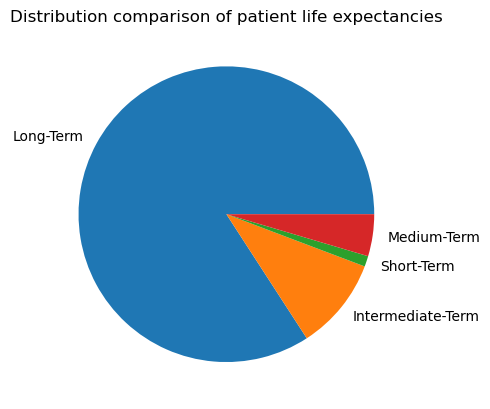

In [3]:
survival_labels, survival_vals = frequencies(clean_data, 'Survival')
pie_chart(survival_vals, survival_labels, "Distribution comparison of patient life expectancies")

Figure 1 provides a pie chart, visualizing the frequency distribution of the 'Survival' class labels throughout the dataset. An observation worth noting is the large amount of cases resulting in 'Long-Term' survival. How will this affect the classifiers performance?

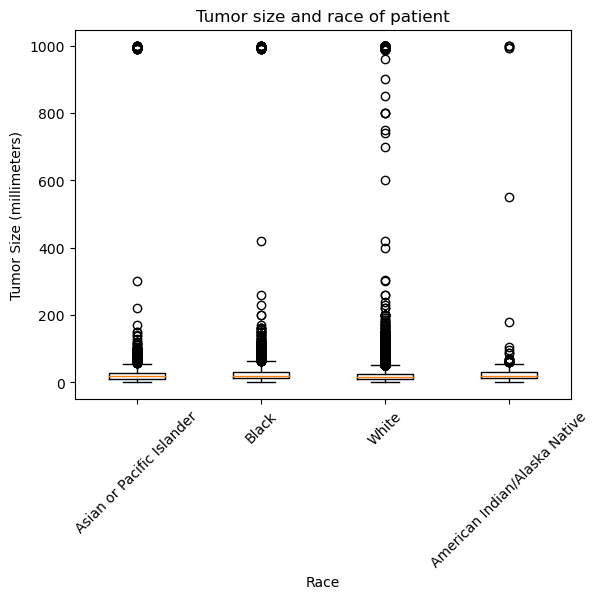

In [4]:
race_labels, race_vals = frequencies(clean_data, 'Race')
r_vals = []
for i in race_labels:
    temp = []
    for j in clean_data:
        if j["Race"] == i:
            temp.append(j['Tumor Size'])
    r_vals.append(temp)
    
box_plot(r_vals, race_labels, "Race", "Tumor Size (millimeters)", "Tumor size and race of patient")

Figure 2 shows a distribution of tumor sizes amongst races using a Box and Whisker plot. There is a near-even distribution of tumor sizes amongst the races, so it could be worth ruling out race as a classification feature.

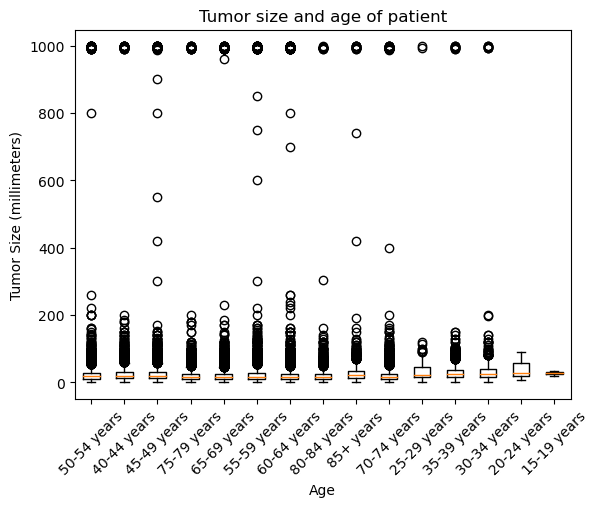

In [5]:
age_labels, age_vals = frequencies(clean_data, 'Age')
a_vals = []
for i in age_labels:
    temp = []
    for j in clean_data:
        if j["Age"] == i:
            temp.append(j['Tumor Size'])
    a_vals.append(temp)
    
box_plot(a_vals, age_labels, "Age", "Tumor Size (millimeters)", "Tumor size and age of patient")

Figure 3 shows a Box and Whisker plot of the patient's tumor size and their age. An observation made from this figure is that tumor instances are more frequent as the age groups progress.

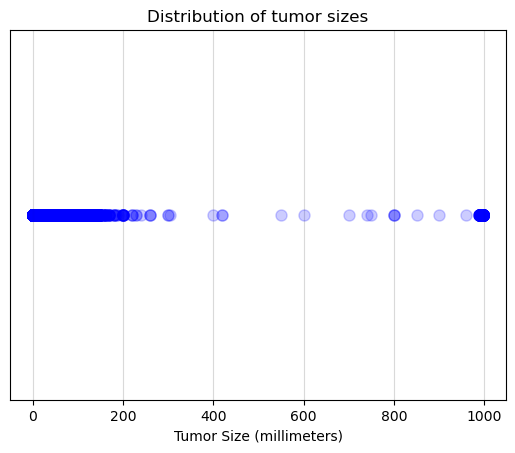

In [6]:
dot_chart(column_values(clean_data, 'Tumor Size'), 'Tumor Size (millimeters)', 'Distribution of tumor sizes')

Figure 4 displays the distribution of tumor sizes throughout the dataset. This is could be reflective of the distribution of survival labels.

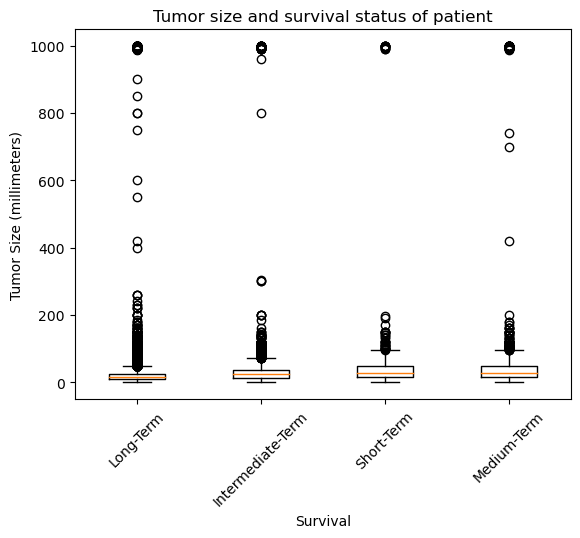

In [7]:
s_vals = []
for i in survival_labels:
    temp = []
    for j in clean_data:
        if j["Survival"] == i:
            temp.append(j['Tumor Size'])
    s_vals.append(temp)
    
box_plot(s_vals, survival_labels, "Survival", "Tumor Size (millimeters)", "Tumor size and survival status of patient")

Figure 5 shows a Box and Whisker that visualizes the correlation between tumor size and the patient's vital status. An observation that may be drawn from this figure is that on average, those with shorter life expectancies tend to have larger tumors.

In [ ]:
for i in range(10):
    print(clean_data[i])

**Data Cleaning**

When cleaning the dataset, a procedure was followed:

1. Remove duplicates
```python
data = remove_duplicates(data)
```
2. Remove missing instances
```python
data = remove_missing(data, data.columns(), {'Tumor Size': [999, 990], 'P_Nodes': [99, 98], ...})
```
* This will remove any missing values, as well as values in the dictionary that aren't explicity defined as missing, but are coded as missing in the SEER documentation. An example is when Tumor Size is 999; according to the <a href="https://seer.cancer.gov/data-software/documentation/seerstat/nov2020/TextData.FileDescription.pdf">SEER documentation</a>, a value of 999 is 'Unknown'.

3. Place 'Survival' values into the standard bins defined by the AJCC
```python
standard_binning(data, 'Survival', [6, 24, 60], ['Short-Term', 'Medium-Term', 'Intermediate-Term', 'Long-Term'])
```

4. Combine 'Surgery? and 'Type' columns to form a new 'Surgical Procedure' column 
```python
combine_dict = {'Not recommended': 'Not recommended', 'Recommended but not performed, unknown reason': 'Recommended but not performed' , ...}
clean_data = combine_features(data, ['Surgery?', 'Type'], combine_dict, 'Surgical Procedure')
```
* To enrich the dataset, it was decided that I should combine the 'Surgery? and 'Type' columns. This resulted in a new column, named 'Surgical Procedure.' Using the <a href="https://seer.cancer.gov/archive/tools/SEER2003.surg.prim.site.codes.pdf">Primary Site Codes</a>, values from the 'Type' column were binned into the 'Mastectomy' or 'Lumpectomy' groups. Values from the 'Surgery' column were binned into the 'Not recommended' or 'Recommended but not performed' groups, if not binned into the previous two groups.

**Features Selected for Classification**
* **Tumor Size**: According to the <a href="https://www.cancer.gov/about-cancer/diagnosis-staging/prognosis#:~:text=Some%20of%20the%20factors%20that%20affect%20prognosis%20include%3A,how%20healthy%20you%20were%20before%20cancer%20More%20items">National Cancer Institute</a>, cancer survivability is strongly associated with tumor size.
* **Positive Lymph Nodes**: According to the <a href="https://www.cancer.org/cancer/types/colon-rectal-cancer/detection-diagnosis-staging/survival-rates.html">American Cancer Society</a>, survival rate drops significantly once cancer spreads to the lymph nodes.
* **Metastasis**: According to the <a href="https://www.mayoclinic.org/diseases-conditions/cancer/in-depth/cancer/art-20044517#:~:text=For%20instance%2C%2060%20percent%20of%20people%20diagnosed%20with,other%20areas%20of%20the%20body%20is%206%20percent.">Mayo Clinic</a>, there is a signficant correlation between five-year survival and whether the cancer has metastasized.
* **Age**: The older one becomes, the more difficult it is to fight disease and illness. Age could be a useful feature for the classifier.
* **Race**: There may be a correlation between race and access to proper medical services or susceptibility to breast cancer.
* **Stage**: According to the <a href="https://www.cancer.gov/about-cancer/diagnosis-staging/prognosis#:~:text=Some%20of%20the%20factors%20that%20affect%20prognosis%20include%3A,how%20healthy%20you%20were%20before%20cancer%20More%20items">National Cancer Institute</a>, the stage of the cancer is a strong factor in one's prognosis.
* **Surgery**: Whether a patient received treatment or not, whether treatment was recommended, and what kind of treatment, are all important decisions that should be known to the classifier.

<h1>Classification Results</h1>

To preface this section, it must be stated that I was unable to utilize the full capacity of this dataset. A memory error would occur, only after a function call to any of my classifiers would last for a protracted period of time. To mend this issue, I've decreased the dataset by a large margin of 34,118 instances, reducing the size of the dataset to 5,000 instances.

In [8]:
seer_data = DataTable(clean_data.columns())
for i in range(5000):
    seer_data.append(clean_data[i].values())

Before developing a tailored classifier for the dataset, I will begin by creating train and test sets using the Holdout method, and will run them over rudimentary versions of K-Nearest Neighbours, Naive Bayes, and Top-Down Induction of Decision Trees. This will help to measure which algorithms work better over the dataset, and minimum requirements for the tailored classifier's performance. 

In [9]:
train_set, test_set = holdout(seer_data, int(seer_data.row_count() * 1/3))

**Simple KNN Approach**

In [10]:
knn_confusion = knn_eval(train_set, test_set, majority_vote, 15, 'Survival', ['Tumor Size', 'P_Nodes', 'Metastasis'], ['Age', 'Race', 'Stage', 'Surgical Procedure'])
print(knn_confusion, '\n')
print('Short-Term Accuracy: ', accuracy(knn_confusion, 'Short-Term'))
print('Medium-Term Accuracy ', accuracy(knn_confusion, 'Medium-Term'))
print('Intermediate-Term Accuracy ', accuracy(knn_confusion, 'Intermediate-Term'))
print('Long-Term Accuracy ', accuracy(knn_confusion, 'Long-Term'))
precision_knn = (precision(knn_confusion, 'Short-Term') + precision(knn_confusion, 'Medium-Term') + precision(knn_confusion, 'Intermediate-Term') + precision(knn_confusion, 'Long-Term'))/4
print('Precision: ', precision_knn)
recall_knn = (recall(knn_confusion, 'Short-Term') + recall(knn_confusion, 'Medium-Term') + recall(knn_confusion, 'Intermediate-Term') + recall(knn_confusion, 'Long-Term'))/4
print('Recall: ', recall_knn)
f_measure_knn = (2 * precision_knn * recall_knn)/(precision_knn + recall_knn)
print('F-Measure: ', f_measure_knn, '\n')

actual               Intermediate-Term    Long-Term    Short-Term    Medium-Term
-----------------  -------------------  -----------  ------------  -------------
Intermediate-Term                    9          169             0              0
Long-Term                            6         1408             0              1
Short-Term                           0           19             0              0
Medium-Term                          8           46             0              0 

Short-Term Accuracy:  0.9885954381752701
Medium-Term Accuracy  0.9669867947178872
Intermediate-Term Accuracy  0.89015606242497
Long-Term Accuracy  0.8553421368547419
Precision:  0.3121988031562781
Recall:  0.2614037003215945
F-Measure:  0.28455218338904054 



**Simple Naive Bayes Approach**

In [11]:
naive_confusion = naive_bayes_eval(train_set, test_set, 'Survival', ['Tumor Size', 'P_Nodes', 'Metastasis'], ['Age', 'Race', 'Stage', 'Surgical Procedure'])
print(naive_confusion, '\n')
print('Short-Term Accuracy: ', accuracy(naive_confusion, 'Short-Term'))
print('Medium-Term Accuracy ', accuracy(naive_confusion, 'Medium-Term'))
print('Intermediate-Term Accuracy ', accuracy(naive_confusion, 'Intermediate-Term'))
print('Long-Term Accuracy ', accuracy(naive_confusion, 'Long-Term'))
precision_nb = (precision(naive_confusion, 'Short-Term') + precision(naive_confusion, 'Medium-Term') + precision(naive_confusion, 'Intermediate-Term') + precision(naive_confusion, 'Long-Term'))/4
print('Precision: ', precision_nb)
recall_nb = (recall(naive_confusion, 'Short-Term') + recall(naive_confusion, 'Medium-Term') + recall(naive_confusion, 'Intermediate-Term') + recall(naive_confusion, 'Long-Term'))/4
print('Recall: ', recall_nb)
f_measure_nb = (2 * precision_nb * recall_nb)/(precision_nb + recall_nb)
print('F-Measure: ', f_measure_nb, '\n')

actual               Intermediate-Term    Long-Term    Short-Term    Medium-Term
-----------------  -------------------  -----------  ------------  -------------
Intermediate-Term                    3          159            13              3
Long-Term                            2         1389            16              8
Short-Term                           1           16             2              0
Medium-Term                          0           42             7              5 

Short-Term Accuracy:  0.968187274909964
Medium-Term Accuracy  0.963985594237695
Intermediate-Term Accuracy  0.8931572629051621
Long-Term Accuracy  0.8541416566626651
Precision:  0.4325033181490463
Recall:  0.299083781191928
F-Measure:  0.3536276894073093 



**Simple Decision Tree Approach**

In [29]:
train_set, test_set = holdout(seer_data, int(seer_data.row_count() * 1/3))
tree_confusion = tdidt_eval(train_set, test_set, 'Survival', ['Age', 'Race', 'Stage', 'Surgical Procedure'])
print(tree_confusion, '\n')
print('Short-Term Accuracy: ', accuracy(tree_confusion, 'Short-Term'))
print('Medium-Term Accuracy ', accuracy(tree_confusion, 'Medium-Term'))
print('Intermediate-Term Accuracy ', accuracy(tree_confusion, 'Intermediate-Term'))
print('Long-Term Accuracy ', accuracy(tree_confusion, 'Long-Term'))
precision_tree = (precision(tree_confusion, 'Short-Term') + precision(tree_confusion, 'Medium-Term') + precision(tree_confusion, 'Intermediate-Term') + precision(tree_confusion, 'Long-Term'))/4
print('Precision: ', precision_tree)
recall_tree = (recall(tree_confusion, 'Short-Term') + recall(tree_confusion, 'Medium-Term') + recall(tree_confusion, 'Intermediate-Term') + recall(tree_confusion, 'Long-Term'))/4
print('Recall: ', recall_tree)
f_measure_tree = (2 * precision_tree * recall_tree)/(precision_tree + recall_tree)
print('F-Measure: ', f_measure_tree, '\n')

actual               Intermediate-Term    Long-Term    Short-Term    Medium-Term
-----------------  -------------------  -----------  ------------  -------------
Intermediate-Term                   11           89             0              1
Long-Term                           29          819             1              6
Short-Term                           2            9             0              0
Medium-Term                          9           21             0              3 

Short-Term Accuracy:  0.988
Medium-Term Accuracy  0.963
Intermediate-Term Accuracy  0.87
Long-Term Accuracy  0.845
Precision:  0.3472051507170032
Recall:  0.28942867971007624
F-Measure:  0.31569521931672023 



**Tailored Classifier**

In choosing an algorithm, I initially opted against a decision tree due to its limitation with categorical attributes, utilizing only half of the intended features for classification.

While initial assessments favored Naive Bayes among the basic classifiers, a closer look at the features introduced some nuances. The assumption of feature independence in Naive Bayes encounters challenges with closely correlated features such as tumor size and stage or positive nodes and metastasis.

Considering these factors, opting for K-Nearest Neighbors gains some merit. However, comparing this against the simple classifier outcomes, Naive Bayes remains a viable choice. Given the high dimensionality and sparsity of the dataset, Naive Bayes becomes a pretty practical option.

In light of these considerations, a tailored adaptation of Naive Bayes was the preferred choice among the three classifiers.

In [19]:
train_set, test_set = bootstrap(seer_data)
naive_confusion = naive_bayes_eval(train_set, test_set, 'Survival', ['Tumor Size', 'P_Nodes', 'Metastasis'], ['Age', 'Race', 'Stage', 'Surgical Procedure'])
print(naive_confusion, '\n')
print('Short-Term Accuracy: ', accuracy(naive_confusion, 'Short-Term'))
print('Medium-Term Accuracy ', accuracy(naive_confusion, 'Medium-Term'))
print('Intermediate-Term Accuracy ', accuracy(naive_confusion, 'Intermediate-Term'))
print('Long-Term Accuracy ', accuracy(naive_confusion, 'Long-Term'))
precision_nb = (precision(naive_confusion, 'Short-Term') + precision(naive_confusion, 'Medium-Term') + precision(naive_confusion, 'Intermediate-Term') + precision(naive_confusion, 'Long-Term'))/4
print('Precision: ', precision_nb)
recall_nb = (recall(naive_confusion, 'Short-Term') + recall(naive_confusion, 'Medium-Term') + recall(naive_confusion, 'Intermediate-Term') + recall(naive_confusion, 'Long-Term'))/4
print('Recall: ', recall_nb)
f_measure_nb = (2 * precision_nb * recall_nb)/(precision_nb + recall_nb)
print('F-Measure: ', f_measure_nb, '\n')

actual               Intermediate-Term    Long-Term    Short-Term    Medium-Term
-----------------  -------------------  -----------  ------------  -------------
Intermediate-Term                    1          106             7              3
Long-Term                            4          900            10              4
Short-Term                           1            7             1              1
Medium-Term                          1           31             4              5 

Short-Term Accuracy:  0.9723756906077348
Medium-Term Accuracy  0.9594843462246777
Intermediate-Term Accuracy  0.8876611418047882
Long-Term Accuracy  0.850828729281768
Precision:  0.3587490096110786
Recall:  0.3027225962304872
F-Measure:  0.32836309412378223 



For my Naive Bayes classifier, I used the bootstrap method to create a train and a test set, as bootstrap doesn't make any assumptions as to the distribution shape. To begin with, I used my stratified Naive Bayes function, but that produced undesireable outputs.

After changing the configurations to my Naive Bayes classifier, like the number of folds for the stratification and the size of the data set, I decided that Naive Bayes wasn't working well with the dataset.

Following an Ockham's Razor approach, I decided to use a decision tree instead. I realized that for a dataset with such high dimensionality, it can be difficult for algorithms like KNN or Naive Bayes to make a proper decision, even when the classification task isn't too hard. Getting too bogged down in the details can be harmful for a classifier, especially considering that the categorical features selected for this classification task should be sufficient.

In [35]:
tree_confusion = tdidt_stratified(seer_data, 32, 'Survival', ['Age', 'Race', 'Stage', 'Surgical Procedure'])
print(tree_confusion, '\n')
print('Short-Term Accuracy: ', accuracy(tree_confusion, 'Short-Term'))
print('Medium-Term Accuracy ', accuracy(tree_confusion, 'Medium-Term'))
print('Intermediate-Term Accuracy ', accuracy(tree_confusion, 'Intermediate-Term'))
print('Long-Term Accuracy ', accuracy(tree_confusion, 'Long-Term'))
precision_tree = (precision(tree_confusion, 'Short-Term') + precision(tree_confusion, 'Medium-Term') + precision(tree_confusion, 'Intermediate-Term') + precision(tree_confusion, 'Long-Term'))/4
print('Precision: ', precision_tree)
recall_tree = (recall(tree_confusion, 'Short-Term') + recall(tree_confusion, 'Medium-Term') + recall(tree_confusion, 'Intermediate-Term') + recall(tree_confusion, 'Long-Term'))/4
print('Recall: ', recall_tree)
f_measure_tree = (2 * precision_tree * recall_tree)/(precision_tree + recall_tree)
print('F-Measure: ', f_measure_tree, '\n')

actual               Intermediate-Term    Long-Term    Short-Term    Medium-Term
-----------------  -------------------  -----------  ------------  -------------
Intermediate-Term                   63          886             8             24
Long-Term                           76         8359            12             42
Short-Term                          18           88             4              5
Medium-Term                         36          340             7             32 

Short-Term Accuracy:  0.9862
Medium-Term Accuracy  0.9546
Intermediate-Term Accuracy  0.8952
Long-Term Accuracy  0.8556
Precision:  0.4075736764130553
Recall:  0.29019932255884007
F-Measure:  0.3390145648001736 



When generating a training and testing set, I found it wise to use a stratified approach. The distribution of class labels in this dataset are quite imbalanced, so stratifying the dataset is a correct decision.

Choosing the amount of folds must be done with tact. Because the dataset is large, a small amount of folds is insufficient. At the same time, too many folds can cause misrepresentation in the training and test sets. I found 32 folds to be a good number for my dataset.

**Results**

On average, the F-scores produced from the classifiers looked somewhat like the following:
* Simple KNN Approach: 28-31
* Simple Naive Bayes Approach: 30-34
* Simple Decision Tree Approach: Anywhere from 28 to 47
* Tailored Naive Bayes: 32-35
* Tailored Decision Tree: 34-38

My observations regarding KNN and Naive Bayes were that they weren't suited well towards such an imbalanced dataset like the SEER dataset. KNN didn't work well because the dataset is so large, and yet so imbalanced, so it predicted nearly everything as "Long-Term." Similar can be said for Naive Bayes. The algorithm incorporates prior probabilities of class occurances in its calculations, which can cause the classifer to become biased towards predicting the majority class more frequently. 

A decision tree was optimal for this classification task because decision trees make fewer assumptions about the underlying data distribution. Decision trees also implicitly deal with imbalanced datasets, as they create branches that address the minority class.

<h1>Conclusion</h1>

This project was inherently difficult to begin with because of the skewed distribution of class labels. Approaches using KNN and Naive Bayes algorithms, which are susceptible to bias, will not perform well on datasets such as the SEER dataset. A Decision Tree approach is strong, as it is capable of representing much of the dataset, while avoiding making any assumptions on the dataset.

To improve this classifiers performance, I believe an ensemble method like Random Forest could be effective. Additionally, a classifier that could take advantage of the correlation between the 'Survival' and 'Stage' attributes would be quite successful.